<a href="https://colab.research.google.com/github/Photonsinnovate/Stanford-cars/blob/main/stanford_cars_using_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install fastai - a pytorch-based deep learning library

In [2]:
!pip install -Uqq fastai 

     |████████████████████████████████| 194kB 9.4MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 


Import fastai's vision module

In [3]:
from fastai.vision.all import *

untar_data downloads URL to fname if destination doesn't exist, and un-tgz or unzip to folder destination.

In [ ]:
path = untar_data(URLs.CARS)

The dataset is divided into train and test set. I used the train for training and the test set for validation 

In [ ]:
image_path = '../input/cars-stanford/'
names = pd.read_csv(image_path+'cars_names.csv', names=['cars'])
train_df = pd.read_csv(image_path+'cars_train.csv', names=['images','bbox1','bbox2','bbox3','bbox4','label'])
test_df = pd.read_csv(image_path+'cars_test.csv', names=['images','bbox1','bbox2','bbox3','bbox4','label'])
names.index += 1

In [ ]:
names_dict = names.to_dict()['cars']

Create a dataframe with the image path, labels an is_valid column as required by the datablock API

In [ ]:
_train_df = train_df.copy()
_train_df['label'] = _train_df.label.map(names_dict)
_train_df['images'] = _train_df.images.map(lambda x : path/'cars_train'/x)
_train_df = _train_df.drop(columns=['bbox1','bbox2','bbox3','bbox4'])
_train_df['is_valid'] = False
_train_df.head(2)

,images,label,is_valid
0,/root/.fastai/data/stanford-cars/cars_train/00001.jpg,Audi TTS Coupe 2012,False
1,/root/.fastai/data/stanford-cars/cars_train/00002.jpg,Acura TL Sedan 2012,False


In [ ]:
_test_df = test_df.copy()
_test_df['label'] = _test_df.label.map(names_dict)
_test_df['images'] = _test_df.images.map(lambda x : path/'cars_test'/x)
_test_df = _test_df.drop(columns=['bbox1','bbox2','bbox3','bbox4'])
_test_df['is_valid'] = True
_test_df.head(2)

,images,label,is_valid
0,/root/.fastai/data/stanford-cars/cars_test/00001.jpg,Suzuki Aerio Sedan 2007,True
1,/root/.fastai/data/stanford-cars/cars_test/00002.jpg,Ferrari 458 Italia Convertible 2012,True


In [ ]:
cat_df = pd.concat([_train_df, _test_df], ignore_index=True)
cat_df.head(2)

,images,label,is_valid
0,/root/.fastai/data/stanford-cars/cars_train/00001.jpg,Audi TTS Coupe 2012,False
1,/root/.fastai/data/stanford-cars/cars_train/00002.jpg,Acura TL Sedan 2012,False


In [ ]:
dls = DataBlock(blocks= (ImageBlock, CategoryBlock),
                get_x = ColReader(0),
                get_y = ColReader(1),
                splitter = ColSplitter('is_valid'),
                item_tfms = Resize(225),
                batch_tfms = aug_transforms()).dataloaders(cat_df, bs=64)

show_batch displays sample images from the training set

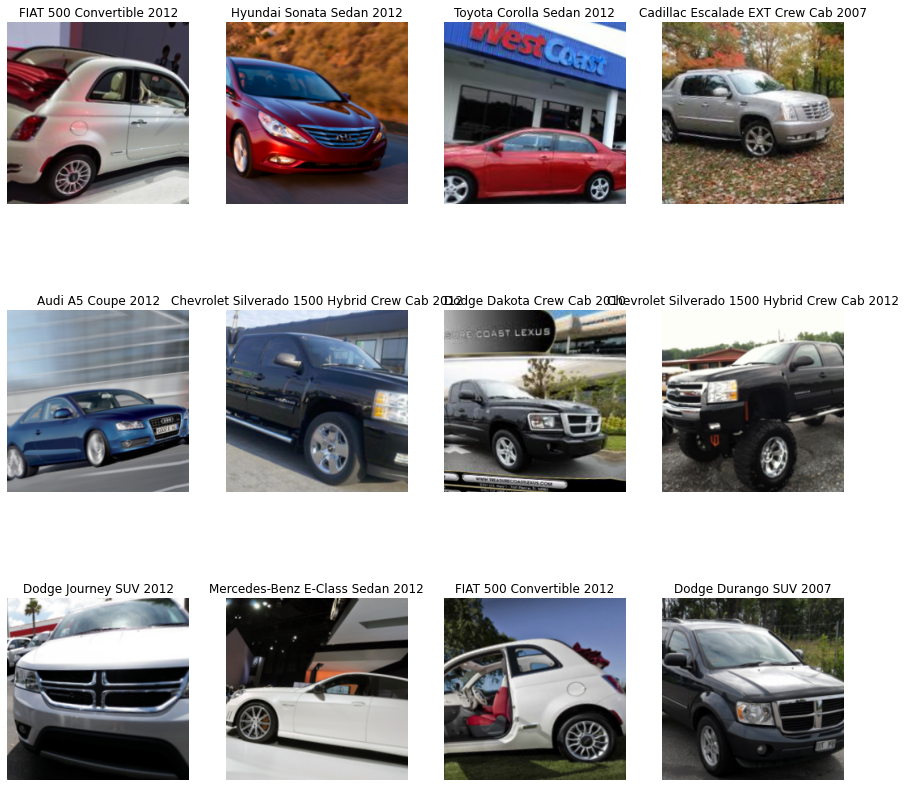

In [ ]:
dls.show_batch(figsize=(15, 15), max_n=12)

cnn_learner is more like a container that takes in the dataloader, model, metrics, loss function

In [ ]:
learn = cnn_learner(dls, resnet101, metrics=[accuracy], cbs=[ShowGraphCallback(), CSVLogger()]).to_native_fp16()

learn.fine_tune is used for transfer learning. In this example we are using a resnet101 as the pretrainmodel.

epoch,train_loss,valid_loss,accuracy,time
0,5.167660,3.545924,0.207437,03:10


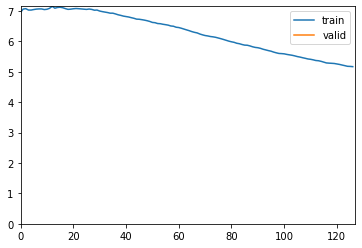

epoch,train_loss,valid_loss,accuracy,time
0,3.210836,2.523846,0.400075,03:17
1,2.441075,1.898326,0.531775,03:16
2,1.847270,1.494858,0.623430,03:15
3,1.427770,1.219518,0.680885,03:17
4,1.119656,1.075925,0.718070,03:15
5,0.892775,1.029181,0.723293,03:15
6,0.754726,0.955722,0.745678,03:17
7,0.662779,0.895978,0.760726,03:19
8,0.578405,0.923625,0.753886,03:17
9,0.548575,0.879045,0.765825,03:17


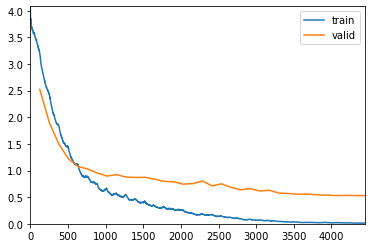

In [ ]:
learn.fine_tune(35)

Training and validation losses have different absolute values but similar trends: indicating that overfitting is under control.

In [ ]:
learn.save('stage_1')

Path('models/stage_1.pth')

In [ ]:
learn.lr_find()

In [ ]:
learn.load('stage_1')

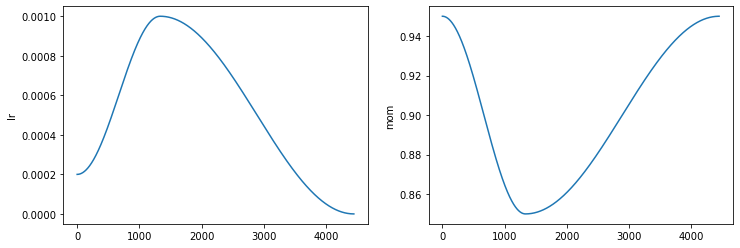

In [ ]:
learn.recorder.plot_sched()